,magnitude,depth,cdi,mmi,sig,alert
0,7.0,14.0,8.0,7.0,0.0,green
1,6.9,25.0,4.0,4.0,-33.0,green
2,7.0,579.0,3.0,3.0,-13.0,green
3,7.3,37.0,5.0,5.0,65.0,green
4,6.6,624.0,0.0,2.0,-98.0,green


,magnitude,depth,cdi,mmi,sig,alert
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300
unique,NaN,NaN,NaN,NaN,NaN,4
top,NaN,NaN,NaN,NaN,NaN,green
freq,NaN,NaN,NaN,NaN,NaN,325
mean,7.061008,50.321538,6.976154,6.939231,-9.749231,NaN
std,0.423738,104.348286,2.244875,1.354774,62.245214,NaN
min,6.500000,2.000000,0.000000,1.000000,-128.000000,NaN
25%,6.700000,12.000000,6.000000,6.000000,-54.000000,NaN
50%,7.000000,19.000000,8.000000,7.000000,-7.000000,NaN
75%,7.300000,38.000000,8.000000,8.000000,31.000000,NaN


Missing per column:
 magnitude    0
depth        0
cdi          0
mmi          0
sig          0
alert        0
dtype: int64


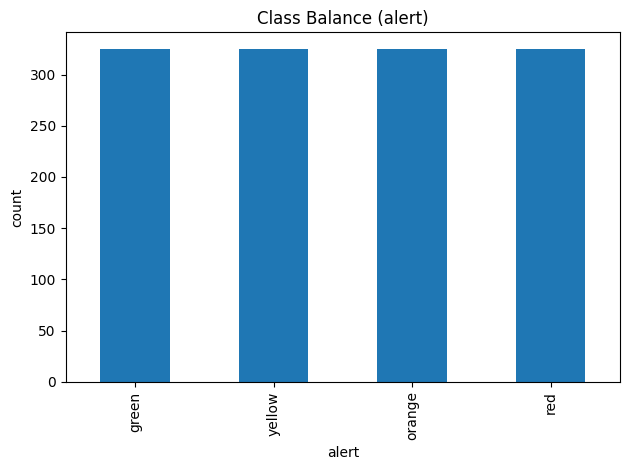

Accuracy: 0.8885

Classification report:
               precision    recall  f1-score   support

       green       0.92      0.85      0.88        65
      orange       0.89      0.85      0.87        65
         red       0.94      0.97      0.95        65
      yellow       0.82      0.89      0.85        65

    accuracy                           0.89       260
   macro avg       0.89      0.89      0.89       260
weighted avg       0.89      0.89      0.89       260



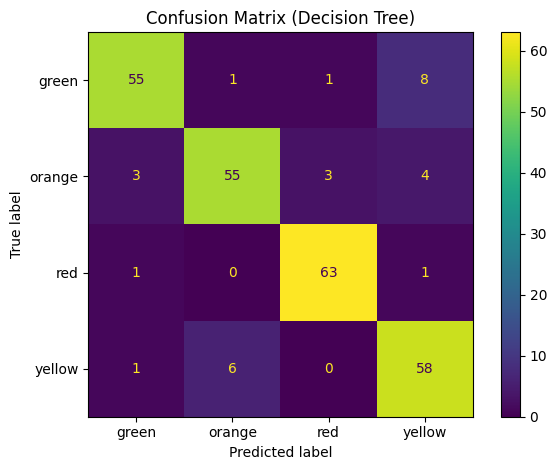

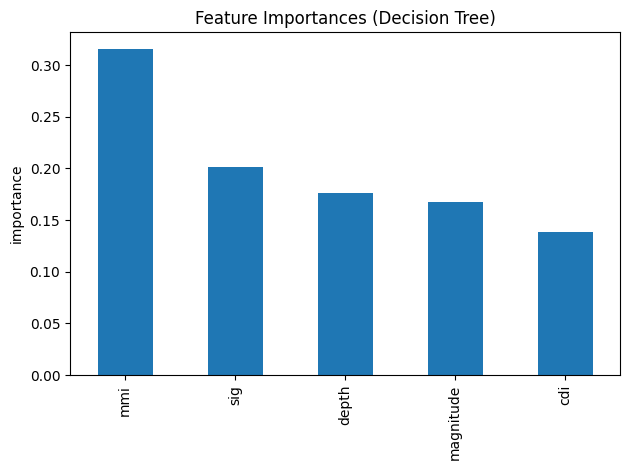

5-fold CV: [0.8538 0.8692 0.8385 0.8808 0.8923] mean = 0.8669
Saved metrics.csv, model, encoder.


In [ ]:
#----------------          ------------------------------------------------#
#
#----------------          ------------------------------------------------#
from pathlib import Path
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score



BASE = Path("AI_project_master")
DATA_PATH   = BASE / "data" / "earthquakes.csv"
METRICS_DIR = BASE / "metrics"
MODELS_DIR  = BASE / "models"
FIG_DIR     = METRICS_DIR / "figs"

METRICS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA_PATH)
display(df.head(), df.describe(include='all'))
print("Missing per column:\n", df.isna().sum())


#----------------          ------------------------------------------------#
#
#----------------          ------------------------------------------------#
df = pd.read_csv(DATA_PATH)
display(df.head(), df.describe(include='all'))
print("Missing per column:\n", df.isna().sum())

#----------------          ------------------------------------------------#
#
#----------------          ------------------------------------------------#
num_cols = [c for c in ["magnitude","depth","cdi","mmi","sig"] if c in df.columns]
# แปลงเป็นตัวเลขและเติมค่าว่าง (หลีกเลี่ยง chained assignment)
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

assert "alert" in df.columns, "ต้องมีคอลัมน์ 'alert'"
le = LabelEncoder()
y = le.fit_transform(df["alert"].astype(str))

#----------------          ------------------------------------------------#
#
#----------------          ------------------------------------------------#
counts = df["alert"].value_counts()
plt.figure()
counts.reindex(counts.index).plot(kind="bar")
plt.title("Class Balance (alert)")
plt.xlabel("alert")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(FIG_DIR / "class_balance.png", dpi=200)
plt.show()

#----------------          ------------------------------------------------#
#
#----------------          ------------------------------------------------#
features = ["magnitude","depth","cdi","mmi","sig"]  # F2_all
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

best_params = {"max_depth": 20, "min_samples_split": 2}  # แนะนำเลือกอันนี้เพราะ generalize กว่า None
clf = DecisionTreeClassifier(random_state=42, **best_params).fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc, 4))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

#----------------          ------------------------------------------------#
#
#----------------          ------------------------------------------------#
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot()
plt.title("Confusion Matrix (Decision Tree)")
plt.tight_layout()
plt.savefig(FIG_DIR / "confusion_matrix.png", dpi=200)
plt.show()

#----------------          ------------------------------------------------#
#
#----------------          ------------------------------------------------#
importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure()
importances.plot(kind="bar")
plt.title("Feature Importances (Decision Tree)")
plt.ylabel("importance")
plt.tight_layout()
plt.savefig(FIG_DIR / "feature_importances.png", dpi=200)
plt.show()

importances

#----------------          ------------------------------------------------#
#
#----------------          ------------------------------------------------#
cv_scores = cross_val_score(
    DecisionTreeClassifier(random_state=42, **best_params),
    X, y, cv=5, scoring="accuracy"
)
print("5-fold CV:", cv_scores.round(4), "mean =", round(cv_scores.mean(),4))


#----------------          ------------------------------------------------#
#
#----------------          ------------------------------------------------#
import joblib
pd.DataFrame([{
    "feature_set": "F2_all",
    "features": ",".join(features),
    "params": str(best_params),
    "accuracy": round(acc, 4)
}]).to_csv(METRICS_DIR / "metrics.csv", index=False)

joblib.dump(clf, MODELS_DIR / "earthquake_model.pkl")
joblib.dump(le,  MODELS_DIR / "label_encoder.pkl")
print("Saved metrics.csv, model, encoder.")


#----------------          ------------------------------------------------#
#
#----------------          ------------------------------------------------#
cv_scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
print(cv_scores, "mean =", round(cv_scores.mean(),4))
